In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

In [3]:
image_classes = os.listdir(data_dir)
print(image_classes)

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [4]:
from datasets import load_dataset
os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/")
os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/test/")


['PNEUMONIA', 'NORMAL']

In [5]:
train_path ="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"


In [6]:
image_classes = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/")
print(image_classes)

['PNEUMONIA', 'NORMAL']


# visualization 

In [7]:
def plot_image(image_classes):
    plt.figure(figsize = (12,12))
    
    for i, category in enumerate(image_classes):
        image_path = train_path + '/' + category
        images_in_folder = os.listdir(image_path)
        
        first_image = images_in_folder[0]
        first_image_path = image_path + '/' + first_image
        
        img = image.load_img(first_image_path)
        img_array = image.img_to_array(img) / 255
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

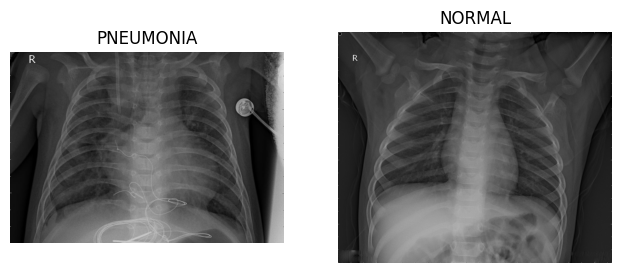

In [8]:
plot_image(image_classes)

# preprocessing

In [9]:
data_generator = ImageDataGenerator(rescale = 1/255)

In [10]:
train_data = data_generator.flow_from_directory(train_path,
                                                target_size = (128, 128),
                                                batch_size = 16,
                                                class_mode='binary',
                                                color_mode='rgb'  # Convert images to grayscale
                                               )

Found 5216 images belonging to 2 classes.


In [11]:
test_data = data_generator.flow_from_directory(test_path,
                                               target_size = (128, 128),
                                               batch_size = 1,
                                               class_mode='binary',
                                               color_mode='rgb'
                                               )

Found 624 images belonging to 2 classes.


In [12]:
val_data = data_generator.flow_from_directory(val_path,
                                              target_size = (128, 128),
                                              batch_size = 16,
                                              class_mode='binary',
                                              color_mode='rgb'
                                               )

Found 16 images belonging to 2 classes.


In [13]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 1, padding = 'same', activation = 'relu',
                input_shape = [128,128,3]))  # Ensure input shape is correct for RGB images
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

# For binary classification, you need a single output unit
model.add(Dense(1, activation = 'sigmoid'))

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,424,001 (32.14 MB)

 Trainable params: 8,424,001 (32.14 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy']
             )

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [19]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/5


I0000 00:00:1726363412.828901     129 service.cc:145] XLA service 0x784fec006800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726363412.828990     129 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/326 ━━━━━━━━━━━━━━━━━━━━ 37:31 7s/step - accuracy: 0.8125 - loss: 0.6745

I0000 00:00:1726363416.503724     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


326/326 ━━━━━━━━━━━━━━━━━━━━ 75s 208ms/step - accuracy: 0.8578 - loss: 0.3833 - val_accuracy: 0.8125 - val_loss: 0.2587
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 46s 137ms/step - accuracy: 0.9634 - loss: 0.0968 - val_accuracy: 0.8125 - val_loss: 0.3947
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - accuracy: 0.9692 - loss: 0.0812 - val_accuracy: 0.9375 - val_loss: 0.2163
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 46s 138ms/step - accuracy: 0.9826 - loss: 0.0434 - val_accuracy: 0.9375 - val_loss: 0.2194
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 46s 137ms/step - accuracy: 0.9910 - loss: 0.0267 - val_accuracy: 0.9375 - val_loss: 0.2055


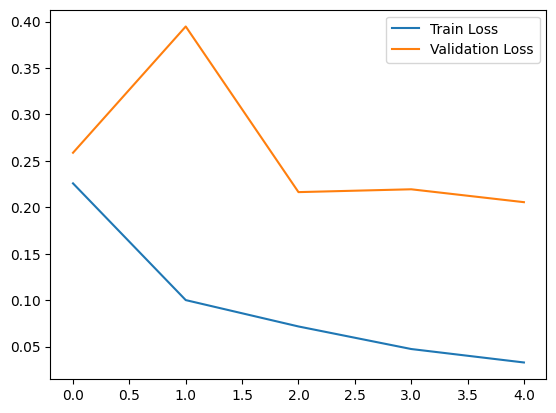

In [20]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

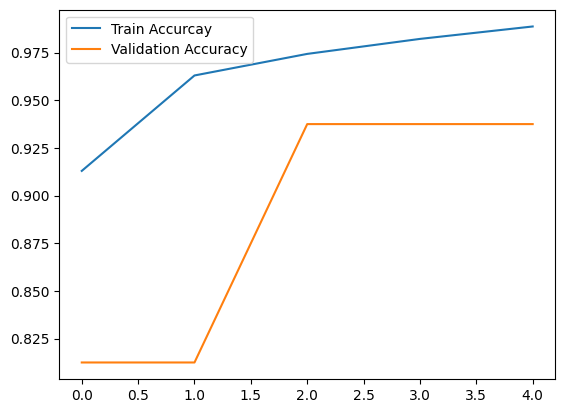

In [21]:
plt.plot(history.history['accuracy'], label = 'Train Accurcay')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [22]:
model.evaluate(test_data)

624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7578 - loss: 0.9503


[1.016089677810669, 0.745192289352417]

In [23]:
class_map = dict([value, key] for key, value in train_data.class_indices.items())

In [24]:
class_map

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [27]:
import numpy as np
def prediction(test_image, actual_label):
    #load & Preprocessing image
    testing_img = image.load_img(test_image, target_size = (128,128))
    test_img_array = image.img_to_array(testing_img) / 255
    
    test_img_input = test_img_array.reshape(1, test_img_array.shape[0],
                                           test_img_array.shape[1],
                                           test_img_array.shape[2])
    
    #make prediction
    predicted_class = np.argmax(model.predict(test_img_input))
    predicted_img = class_map[predicted_class]
    
    plt.figure(figsize = (4,4))
    plt.imshow(test_img_array)
    plt.title('Actual Label : {}, Predicted Label : {}'.format(actual_label, predicted_img))
    
    plt.grid()
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


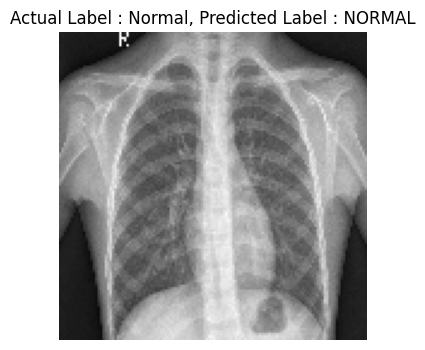

In [28]:
test_image = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
prediction(test_image, actual_label = 'Normal')